# Imports

In [156]:
from sre_parse import Tokenizer
import zipfile

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_precision_recall
from scikitplot.estimators import plot_feature_importances


import langdetect
from cleantext import clean
from imblearn.over_sampling import RandomOverSampler

import gensim.downloader as api

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences


# Checking GPU

In [157]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))


2.10.0
Num GPUs Available:  1


# Setting seeds

In [158]:
seed = 42
langdetect.DetectorFactory = seed
np.random.seed = seed


# Constants and hyperparameters

In [159]:
BATCH_SIZE = 64
EPOCHS = 100


# Downloading dataset

In [160]:
!kaggle datasets download -d advaypatil/youtube-statistics

youtube-statistics.zip: Skipping, found more recently modified local copy (use --force to force download)


In [161]:
dataset = zipfile.ZipFile("youtube-statistics.zip")
dataset.extractall("dataset")


# Loading data to dataframe

In [162]:
df = pd.read_csv("dataset/comments.csv")


In [163]:
df.head(5)


,Unnamed: 0,Video ID,Comment,Likes,Sentiment
0,0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95.0,1.0
1,1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19.0,0.0
2,2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161.0,2.0
3,3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8.0,0.0
4,4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34.0,2.0


# Adding a column with information about language of comment

In [164]:
def add_languge(row):
    try:
        lang = langdetect.detect(row)
    except:
        lang = np.nan
    return lang


df["lang"] = df["Comment"].apply(add_languge)
df.sample(5)


,Unnamed: 0,Video ID,Comment,Likes,Sentiment,lang
7460,7460,Q7a2gKchVlc,"I'm a simple person,I see rindou I click",21.0,1.0,it
3841,3841,rRlyx054z20,Rrespekt nga Shqiptarët e Dibrës Madhe\n🇽🇰🇦🇱,23.0,1.0,sq
13583,13583,Hxd1TNgSuPg,Thanks a lot sir.\nThis video helped a lot to ...,6.0,2.0,en
1767,1767,LWxUb_dwd-0,Love the advice you give! This is something I ...,4.0,2.0,en
16770,16770,2FYvHn12pOQ,Krk reviews should be released in theatres all...,90.0,2.0,en


In [165]:
df = df.dropna()
df = df.loc[df["lang"] == "en"]
print(df["lang"].unique())
print(df["Comment"].isna().any())


['en']
False


In [166]:
df.sample(5)


,Unnamed: 0,Video ID,Comment,Likes,Sentiment,lang
17898,17898,ueNhxQ2lYOM,"+1 to engagement metrics.\n\nAlso, after a yea...",51.0,2.0,en
9093,9093,Wxdj970RM7M,"As a West Virginian, I can confirm that pepper...",9.0,2.0,en
8000,8000,GJj8DmOMvUU,Let’s take a moment to appreciate the other ch...,346.0,2.0,en
1261,1261,AqvyzO3IPXc,People don't realize exactly how hard that ste...,336.0,1.0,en
14235,14235,K-Fc08X56R0,The slow-mo audio of the ring falling down the...,23.0,2.0,en


# Splitting dataset to X and y variables

In [167]:
X = df.drop(columns=["Unnamed: 0", "Video ID", "Likes", "Sentiment", "lang"])
y = df["Sentiment"].astype(int)


In [168]:
y.value_counts()


2    10695
1     3338
0     2300
Name: Sentiment, dtype: int64

### In dataset there is information about our y:
> *A value of zero represents a negative sentiment, whereas values of 
> one and two represent neutral*

Because of that I am changing all values from "2" to "1".

(https://www.kaggle.com/datasets/advaypatil/youtube-statistics)


In [169]:
y_binary = y.apply(lambda x: np.where(x >= 1, 1, 0))
y_binary.value_counts()


1    14033
0     2300
Name: Sentiment, dtype: int64

## Splitting dataset to training and test data

In [170]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=seed
)
len(X_train), len(X_test), len(y_train), len(y_test)


(13066, 3267, 13066, 3267)

In [171]:
X_train.sample(10)


,Comment
16231,This trailer felt so promising. Can't believe ...
9039,the song itself is magical
9401,The host is absolutely so kind. Loved the Hosp...
5947,I used this script exactly the way Sifu worded...
5079,Most excited for the mixed reality headsets. W...
12378,hi! I am a junior and I am starting my first S...
567,Going to be a lot of people upset when they re...
13793,Bought two as a present for my wife. They're i...
10494,🎶 | Tracklist\r\n[00:00] Kanisan ft. Wishes a...
1620,That forward flip where he partially vaults of...


### We can see that our data are imbalanced. We will use ***imblearn*** to deal with it. 

In [172]:
y_train.value_counts()


1    11228
0     1838
Name: Sentiment, dtype: int64

In [173]:
oversample = RandomOverSampler(sampling_strategy="minority")
X_over, y_over = oversample.fit_resample(X_train, y_train)


In [174]:
len(X_over), len(y_over), y_over.value_counts()


(22456,
 22456,
 1    11228
 0    11228
 Name: Sentiment, dtype: int64)

In [175]:
X_over


,Comment
0,Watching the DXY's huge red candle fall from t...
1,"When it comes to investing, diversification is..."
2,This put me in a total self care mood for toni...
3,Repeat with me: don't skip the math.
4,Rick Jones becoming Abomination is also probab...
...,...
22451,You know things are desperate when your furnit...
22452,"As a 33 year veteran teacher, I suggest that y..."
22453,"""She was my life, she filled my soul, she was ..."
22454,"I live in the Netherlands, Europe. And got new..."


# Removing emoticons and other unwanted characters

In [176]:
def clean_text(data):
    data = data.apply(
        lambda x: clean(x, no_emoji=True, no_line_breaks=True, no_punct=True)
    )
    return data


X_train_cleaned = clean_text(X_over["Comment"])
X_train_cleaned.sample(5)


16283    that saints row reboot looked disappointing fr...
681      please turn on english subtitles weoneobsi sos...
14920                              yikes going to the core
6950     i really love her and think that she doesnt de...
7172     jimmy gives a ghost 10k and 20k to give them a...
Name: Comment, dtype: object

In [177]:
X_test_cleaned = clean_text(X_test["Comment"])


In [178]:
max_words_in_sentence = 150
max_words_in_vocab = 20_000

tokenizer = Tokenizer(oov_token="UNK", num_words=max_words_in_vocab)
tokenizer.fit_on_texts(X_train_cleaned)

X_train_seq = tokenizer.texts_to_sequences(X_train_cleaned)
X_train_seq[0]


[162,
 2,
 15622,
 394,
 888,
 12601,
 921,
 43,
 2,
 12602,
 8,
 98,
 3,
 21,
 26,
 162,
 15623,
 7552,
 921,
 9,
 2,
 3108,
 14,
 2,
 105,
 55,
 6,
 56,
 21,
 162,
 12,
 16,
 12603,
 17,
 6896,
 2103,
 4,
 12604,
 10171]

In [179]:
X_test_seq = tokenizer.texts_to_sequences(X_test_cleaned)


In [180]:
X_train_padded = pad_sequences(
    X_train_seq, maxlen=max_words_in_sentence, padding="post"
)
X_train_padded[0]


array([  162,     2, 15622,   394,   888, 12601,   921,    43,     2,
       12602,     8,    98,     3,    21,    26,   162, 15623,  7552,
         921,     9,     2,  3108,    14,     2,   105,    55,     6,
          56,    21,   162,    12,    16, 12603,    17,  6896,  2103,
           4, 12604, 10171,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [181]:
len(y_over)


22456

In [182]:
print(len(X_train_padded))


22456


In [183]:
X_test_padded = pad_sequences(X_test_seq, maxlen=max_words_in_sentence, padding="post")


# Downloading GloVe embeddings

In [184]:
glove = api.load("glove-wiki-gigaword-200")


## Preparing embeddings

In [185]:
words_embeddings = np.zeros((max_words_in_vocab + 1, 200))


In [186]:
for word, index in tokenizer.word_index.items():
    try:
        vector = glove.get_vector(word)
        words_embeddings[index] = vector
    except KeyError as e:
        print(f"Error: {e}")

    if index == len(words_embeddings) - 1:
        break


Error: "Key 'UNK' not present"
Error: "Key 'youve' not present"
Error: "Key 'lmao' not present"
Error: "Key 'werent' not present"
Error: "Key 'theyve' not present"
Error: "Key 'shouldnt' not present"
Error: "Key 'wouldve' not present"
Error: "Key 'asmr' not present"
Error: "Key 'lofi' not present"
Error: "Key 'tradng' not present"
Error: "Key 'pumpspumped' not present"
Error: "Key 'pumpsnarrowly' not present"
Error: "Key 'tradiing' not present"
Error: "Key 'itll' not present"
Error: "Key 'wtrade' not present"
Error: "Key 'ps5' not present"
Error: "Key 'theyd' not present"
Error: "Key 'denuvo' not present"
Error: "Key 'binance' not present"
Error: "Key 'viserys' not present"
Error: "Key 'rhaenys' not present"
Error: "Key 'gamepass' not present"
Error: "Key 'idk' not present"
Error: "Key 'shouldve' not present"
Error: "Key 'casemiro' not present"
Error: "Key 'httpswwwyoutubecomwatchv' not present"
Error: "Key 'n3on' not present"
Error: "Key 'theyll' not present"
Error: "Key 'splatoon' no

# Creating a model without recurrent layers

In [187]:
model_no_rnn = Sequential()
model_no_rnn.add(
    Embedding(
        max_words_in_vocab + 1,
        200,
        weights=[words_embeddings],
        input_length=max_words_in_sentence,
        trainable=False,
    )
)
model_no_rnn.add(Flatten())
model_no_rnn.add(Dense(64, activation="relu"))
model_no_rnn.add(Dropout(0.2))
model_no_rnn.add(Dense(32, activation="relu"))
model_no_rnn.add(Dropout(0.3))
model_no_rnn.add(Dense(16, activation="relu"))
model_no_rnn.add(Dropout(0.5))
model_no_rnn.add(Dense(1, activation="sigmoid"))


In [188]:
model_no_rnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
print(model_no_rnn.summary())


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 150, 200)          4000200   
                                                                 
 flatten_3 (Flatten)         (None, 30000)             0         
                                                                 
 dense_17 (Dense)            (None, 64)                1920064   
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_19 (Dense)            (None, 16)               

# Creating a model with recurrent layers

In [189]:
model_rnn = Sequential()
model_rnn.add(
    Embedding(
        max_words_in_vocab + 1,
        200,
        weights=[words_embeddings],
        input_length=max_words_in_sentence,
        trainable=False,
    )
)
model_rnn.add(LSTM(64, return_sequences=False))
model_rnn.add(Dense(1, activation="sigmoid"))


In [190]:
model_rnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
print(model_rnn.summary())


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 150, 200)          4000200   
                                                                 
 lstm_5 (LSTM)               (None, 64)                67840     
                                                                 
 dense_21 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,068,105
Trainable params: 67,905
Non-trainable params: 4,000,200
_________________________________________________________________
None


# Training models

## Without recurrent layers

In [191]:
filepath = "models/model_no_rnn.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor="val_loss", verbose=1, save_best_only=True, mode="min"
)
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)
callbacks_list = [checkpoint, es]

model_no_rnn.fit(
    X_train_padded,
    y_over,
    validation_split=0.2,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks_list,
)


Epoch 1/100
266/281 [===========================>..] - ETA: 0s - loss: 0.5918 - accuracy: 0.6701
Epoch 1: val_loss improved from inf to 0.55544, saving model to models\model_no_rnn.h5
281/281 [==============================] - 2s 4ms/step - loss: 0.5853 - accuracy: 0.6762 - val_loss: 0.5554 - val_accuracy: 0.7640
Epoch 2/100
269/281 [===========================>..] - ETA: 0s - loss: 0.3728 - accuracy: 0.8437
Epoch 2: val_loss improved from 0.55544 to 0.22766, saving model to models\model_no_rnn.h5
281/281 [==============================] - 1s 3ms/step - loss: 0.3701 - accuracy: 0.8447 - val_loss: 0.2277 - val_accuracy: 0.9314
Epoch 3/100
265/281 [===========================>..] - ETA: 0s - loss: 0.2403 - accuracy: 0.9070
Epoch 3: val_loss did not improve from 0.22766
281/281 [==============================] - 1s 3ms/step - loss: 0.2408 - accuracy: 0.9067 - val_loss: 0.2491 - val_accuracy: 0.9074
Epoch 4/100
270/281 [===========================>..] - ETA: 0s - loss: 0.1646 - accuracy: 0

## With reccurent layers

In [192]:
filepath = "models/model_rnn.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor="val_loss", verbose=1, save_best_only=True, mode="min"
)
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)
callbacks_list = [checkpoint, es]

model_rnn.fit(
    X_train_padded,
    y_over,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=callbacks_list,
)


Epoch 1/100
280/281 [============================>.] - ETA: 0s - loss: 0.6650 - accuracy: 0.6259
Epoch 1: val_loss improved from inf to 0.94977, saving model to models\model_rnn.h5
281/281 [==============================] - 5s 14ms/step - loss: 0.6650 - accuracy: 0.6259 - val_loss: 0.9498 - val_accuracy: 0.0196
Epoch 2/100
279/281 [============================>.] - ETA: 0s - loss: 0.6657 - accuracy: 0.6271
Epoch 2: val_loss improved from 0.94977 to 0.93993, saving model to models\model_rnn.h5
281/281 [==============================] - 4s 13ms/step - loss: 0.6657 - accuracy: 0.6270 - val_loss: 0.9399 - val_accuracy: 0.0129
Epoch 3/100
277/281 [============================>.] - ETA: 0s - loss: 0.6580 - accuracy: 0.6311
Epoch 3: val_loss improved from 0.93993 to 0.92387, saving model to models\model_rnn.h5
281/281 [==============================] - 4s 14ms/step - loss: 0.6580 - accuracy: 0.6310 - val_loss: 0.9239 - val_accuracy: 0.0185
Epoch 4/100
279/281 [============================>.] 

# Loading saved models

In [193]:
model_rnn = tf.keras.models.load_model("models/model_rnn.h5")
model_no_rnn = tf.keras.models.load_model("models/model_no_rnn.h5")


# Evaluating models

In [194]:
rnn_eval = model_rnn.evaluate(X_test_padded, y_test)
no_rnn_eval = model_no_rnn.evaluate(X_test_padded, y_test)


103/103 [==============================] - 0s 2ms/step - loss: 1.6765 - accuracy: 0.8675


In [195]:
rnn_train_pred = model_rnn.predict(X_train_padded)
no_rnn_train_pred = model_no_rnn.predict(X_train_padded)

rnn_test_pred = model_rnn.predict(X_test_padded)
no_rnn_test_pred = model_no_rnn.predict(X_test_padded)


103/103 [==============================] - 0s 843us/step


In [196]:
rnn_train_pred = np.where(rnn_train_pred > 0.5, 1, 0)
no_rnn_train_pred = np.where(no_rnn_train_pred > 0.5, 1, 0)

rnn_test_pred = np.where(rnn_test_pred > 0.5, 1, 0)
no_rnn_test_pred = np.where(no_rnn_test_pred > 0.5, 1, 0)


## Accuracy

### Training data

In [197]:
print("RNN train acc: ", accuracy_score(y_true=y_over, y_pred=rnn_train_pred))
print("No RNN train acc: ", accuracy_score(y_true=y_over, y_pred=no_rnn_train_pred))


RNN train acc:  0.9961257570359815
No RNN train acc:  0.9998218738867118


### Test data

In [198]:
print("RNN test acc: ", accuracy_score(y_true=y_test, y_pred=rnn_test_pred))
print("No RNN test acc: ", accuracy_score(y_true=y_test, y_pred=no_rnn_test_pred))


RNN test acc:  0.8803183348637894
No RNN test acc:  0.8674625038261402


## Precision

### Training data

In [199]:
print("RNN train precision: ", precision_score(y_true=y_over, y_pred=rnn_train_pred))
print(
    "No RNN train precision: ", precision_score(y_true=y_over, y_pred=no_rnn_train_pred)
)


RNN train precision:  0.9928337609484208
No RNN train precision:  1.0


### Test data

In [200]:
print("RNN test precision: ", precision_score(y_true=y_test, y_pred=rnn_test_pred))
print(
    "No RNN test precision: ", precision_score(y_true=y_test, y_pred=no_rnn_test_pred)
)


RNN test precision:  0.9111035422343324
No RNN test precision:  0.8958611481975968


## Recall

### Training data

In [201]:
print("RNN test recall: ", recall_score(y_true=y_over, y_pred=rnn_train_pred))
print("No RNN test recall: ", recall_score(y_true=y_over, y_pred=no_rnn_train_pred))


RNN test recall:  0.9994656216601354
No RNN test recall:  0.9996437477734236


### Test data

In [202]:
print("RNN test recall: ", recall_score(y_true=y_test, y_pred=rnn_test_pred))
print("No RNN test recall: ", recall_score(y_true=y_test, y_pred=no_rnn_test_pred))


RNN test recall:  0.9536541889483066
No RNN test recall:  0.9568627450980393


## Confusion matrix

### Training data

<AxesSubplot: title={'center': 'RNN'}, xlabel='Predicted label', ylabel='True label'>

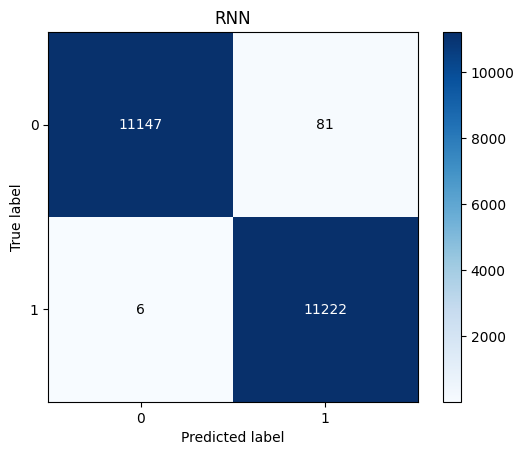

In [203]:
plot_confusion_matrix(y_true=y_over, y_pred=rnn_train_pred, title="RNN")

<AxesSubplot: title={'center': 'No RNN'}, xlabel='Predicted label', ylabel='True label'>

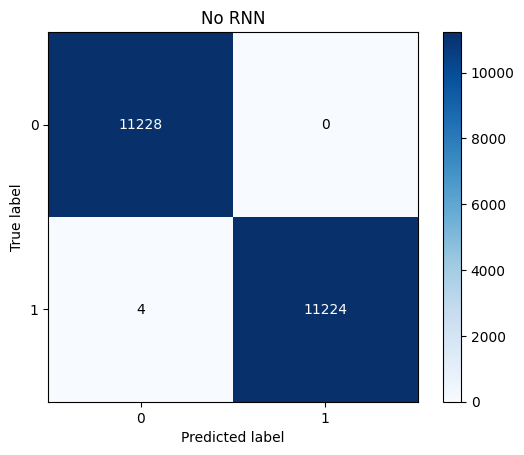

In [204]:
plot_confusion_matrix(y_true=y_over, y_pred=no_rnn_train_pred, title="No RNN")

### Test data

<AxesSubplot: title={'center': 'RNN'}, xlabel='Predicted label', ylabel='True label'>

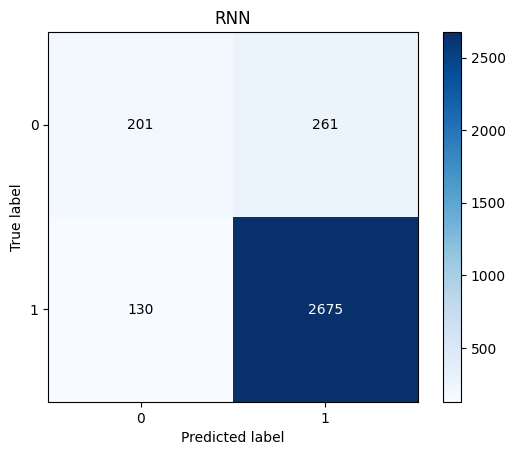

In [205]:
plot_confusion_matrix(y_true=y_test, y_pred=rnn_test_pred, title="RNN")

<AxesSubplot: title={'center': 'No RNN'}, xlabel='Predicted label', ylabel='True label'>

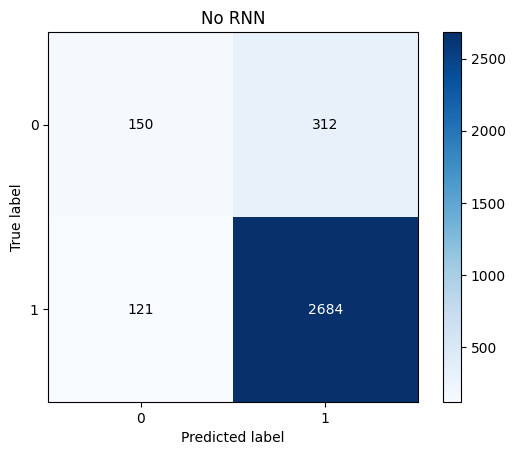

In [206]:
plot_confusion_matrix(y_true=y_test, y_pred=no_rnn_test_pred, title="No RNN")